# Medical Imaging Embeddings Bake-Off: How Microsoft's MedImageInsight Compares to Leading Models

This notebook provides a framework for comparing medical imaging foundation models using lightweight adapter classifiers. Building on research conducted in collaboration with the University of Wisconsin-Madison, this tutorial shows how to benchmark foundation model embeddings by training multiple classifier types and comparing their performance on a multi-class classification task.

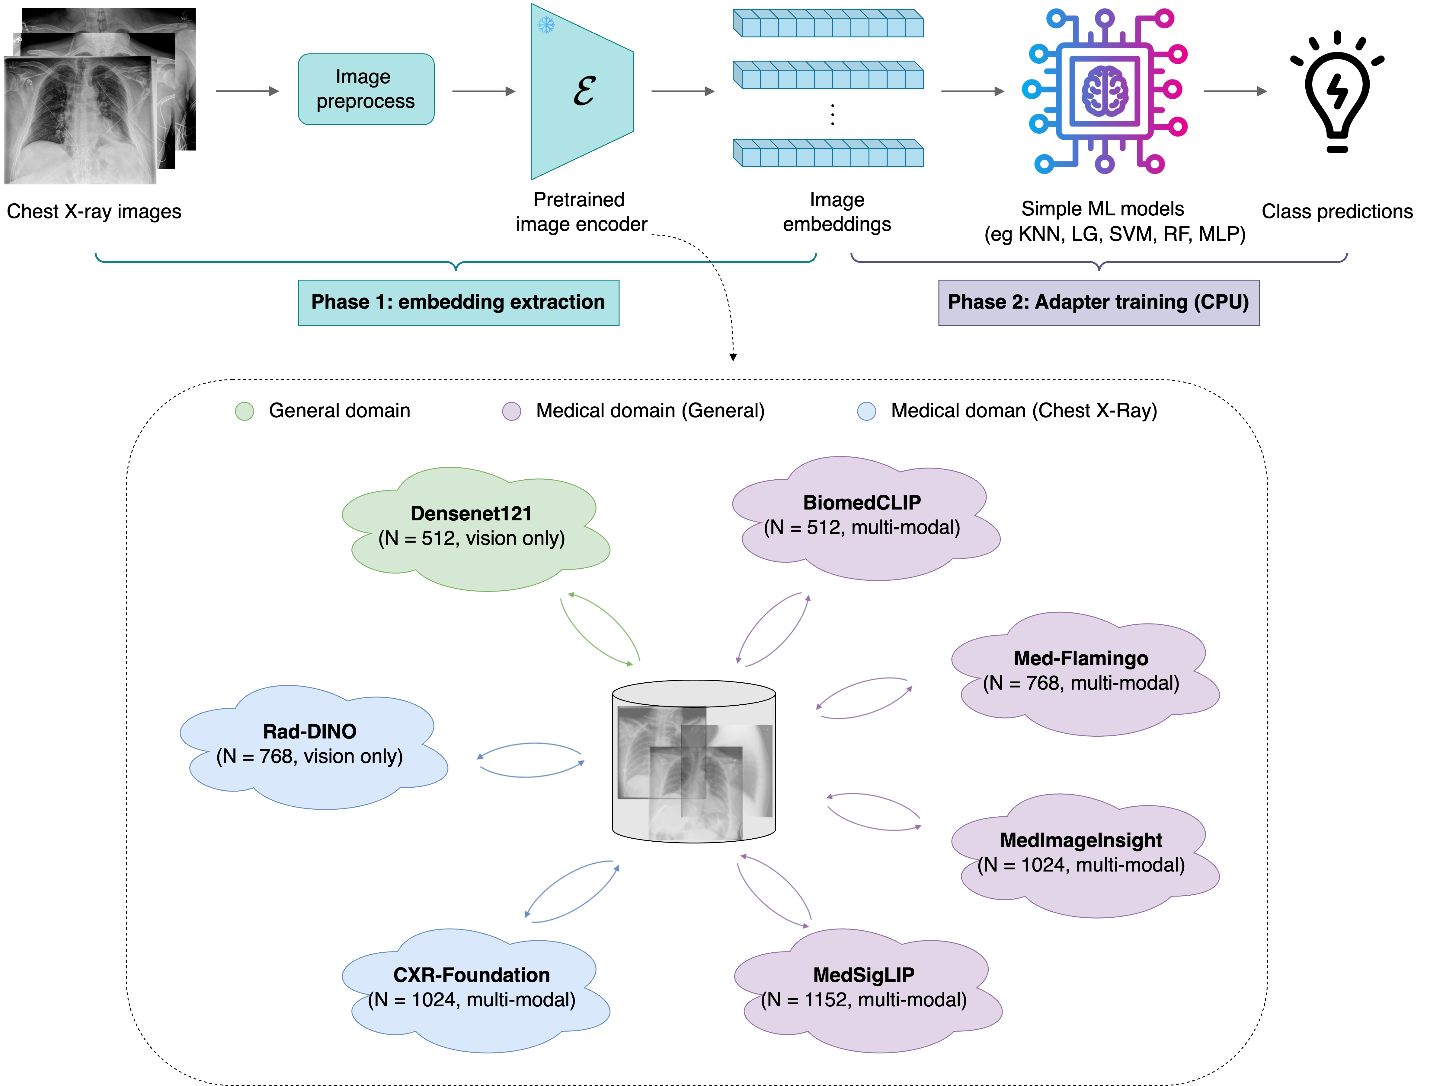

## Background

In collaboration with the University of Wisconsin-Madison, we evaluated MedImageInsight (MI2) against six other leading foundation models, including BiomedCLIP, Med-Flamingo, MedSigLIP, Rad-DINO, CXR-Foundation, and a fine-tuned DenseNet121, on 8,842 chest radiographs spanning seven diagnostic categories. The evaluation used real clinical data to test how well each model's embeddings perform when paired with lightweight adapter classifiers.

**Key Findings:**
- **MedImageInsight achieved 93.1% mAUC**, outperforming all competing foundation models with a 2.1 percentage point improvement over the next-best performer (MedSigLIP at 91.0%)
- **Foundation model adapters surpassed traditional CNNs**: MI2's lightweight adapters exceeded the 87.2% mAUC of a fully fine-tuned DenseNet121, while training in minutes on CPU versus hours on GPU
- **Support Vector Machines emerged as optimal adapters** for most foundation models, demonstrating that high-quality embeddings enable simple classifiers to achieve excellent performance
- **Consistent and reliable predictions**: MI2 showed the lowest performance variability across test folds, indicating robust generalization

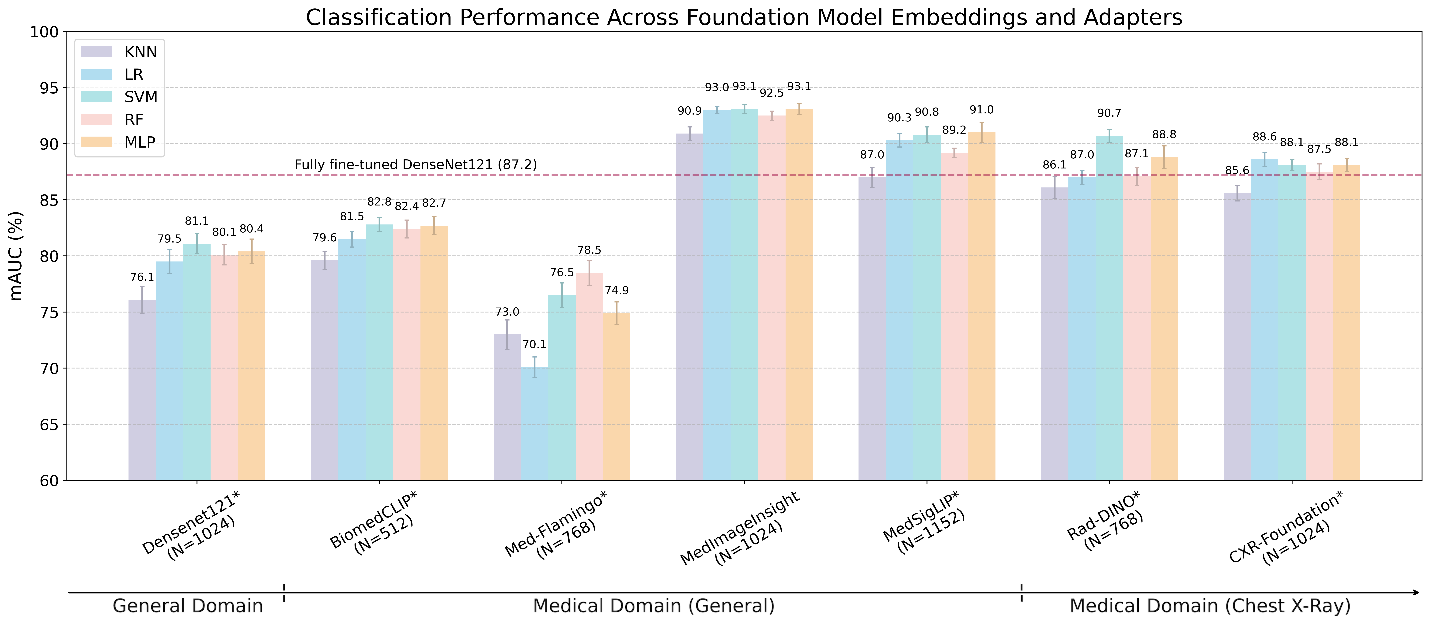

**Learn More:**
- **Research Paper**: [From Embeddings to Accuracy: Comparing Foundation Models for Radiographic Classification](https://arxiv.org/abs/2505.10823)
- **Blog Post**: [Medical Imaging Embeddings Bake-Off: How Microsoft's MedImageInsight Compares to Leading Models](https://aka.ms/hls-frontiers-mi2-bake-off-blog)

## Notebook Overview

This notebook is organized into two parts: Part 1 generates embeddings using MedImageInsight (MI2), while Part 2 trains and evaluates multiple classifier types on those embeddings to compare performance. To compare multiple models, run Part 1 for MI2, then generate embeddings from other models (using their respective tools) in the same JSONL format and run Part 2 for each model's embeddings.

**Part 1: Embedding Generation** (MI2-specific)
1. **Data Loading and Embedding Extraction**
   - Load your chosen dataset
   - Generate 1024-dimensional embedding vectors using MedImageInsight
   - Save embeddings in JSONL format for efficient reuse and model comparison

**Part 2: Model Comparison** (works with any embeddings)

2. **Train Multiple Adapter Classifiers**
   - Train five different classifier types: K-Nearest Neighbors, Logistic Regression, Support Vector Machines, Random Forest, and Multi-Layer Perceptron
   - Optimize hyperparameters using grid search with cross-validation

3. **Evaluate and Compare Model Performance**
   - Measure performance using mAUC, accuracy, precision, recall, and F1 score
   - Compare inference times and computational efficiency

4. **Visualize Results and Embedding Quality**
   - Use UMAP and t-SNE to visualize how embeddings separate diagnostic classes
   - Generate confusion matrices to understand misclassification patterns

> ⚠️ **Note:** While the original study used 8,842 chest radiographs from real clinical data, this notebook provides a simplified example using simpler datasets to illustrate the methodology.

## Prerequisites

This notebook requires the following setup. If you haven't completed these steps, please refer to the Getting Started section in the main README, which includes:

1. Deploying required models
2. Installing the Healthcare AI Toolkit
3. Downloading sample data
4. Configuring your `.env` file

### Required for This Notebook

- **Model Endpoint(s)**: `MI2_MODEL_ENDPOINT` 
- **Additional Dependencies**: `seaborn`

### Dataset Options

**Option 1: Example 100-image dataset** (quick demo)
- Already available downloaded the sample data
- 100 chest X-ray DICOM images with 5 diagnostic categories

**Option 2: COVID-19 Pneumonia dataset** (more similar to the puplication)
- Requires a Kaggle account, **not distributed with sample data**
- Download from [Kaggle](https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia): 6,432 JPG images, 3 classes
- Extract to `<DATA_ROOT>/cxr-covid19-pneumonia/` with `train/` and `test/` subdirectories

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns

# Part 1: Embedding Generation (MedImageInsight)
This part demonstrates how to generate embeddings using MedImageInsight. If you already have embeddings (from MI2 or another model) in JSONL format, you can skip to **Part 2**

## 1. Data Loading and Embedding Extraction

Generate embeddings from MedImageInsight and save them in JSONL format.

**Workflow:**
1. Select dataset and define output paths
2. Load images and generate 1024-dimensional embeddings
3. Save to JSONL for reuse and comparison

**JSONL Format** (one record per line):
```json
{"image_path": "relative/path/image.jpg", "label": "class_name", "image_features": [[0.123, -0.456, ...]]}
```

This format enables comparing multiple foundation models—generate embeddings from each model in separate directories, then run Part 2 for each.


### Configuration

**Choose your dataset** by setting `dataset_name`:
- `"example_100img"` - Quick demo with 100 DICOM images
- `"cxr-covid19-pneumonia"` - Full evaluation with 6,432 JPG images

**Directory Structure:** Embeddings are saved in `{data_root}/mi2-model-comparison/{dataset_name}/{model_name}/`


In [ ]:
from healthcareai_toolkit import settings
import json

data_root = settings.DATA_ROOT

## Configuration - Choose your dataset
## Option 1: Quick demo with 100 DICOM images (included)
# dataset_name = "example_100img"

# Option 2: Full evaluation with 6,432 JPG images (requires download from Kaggle)
dataset_name = "cxr-covid19-pneumonia"

model_name = "mi2"  # Foundation model identifier

# Create directory structure: {data_root}/{dataset_name}/{model_name}/
embedding_dir = os.path.join(
    data_root, "mi2-model-comparison", dataset_name, model_name
)
os.makedirs(embedding_dir, exist_ok=True)

# Standard file names
train_output_file = os.path.join(embedding_dir, "train_embeddings.jsonl")
test_output_file = os.path.join(embedding_dir, "test_embeddings.jsonl")

print(f"Dataset: {dataset_name}")
print(f"Model: {model_name}")
print(f"Embedding directory: {embedding_dir}")
print(
    f"\nEmbeddings exist: Train={os.path.exists(train_output_file)}, Test={os.path.exists(test_output_file)}"
)

Dataset: cxr-covid19-pneumonia
Model: mi2
Embedding directory: /home/azureuser/data/healthcare-ai/mi2-model-comparison/cxr-covid19-pneumonia/mi2

Embeddings exist: Train=False, Test=False


### Load Dataset

Load images if embeddings don't already exist. Returns DataFrames with `image_path` and `label` columns.


In [ ]:
def load_dataset_example(image_root, csv_root):
    """
    Load the example 100-image dataset (DICOM format).

    Returns:
        tuple: (train_df, test_df)
            - train_df: DataFrame with columns ['image_path', 'label']
            - test_df: DataFrame with columns ['image_path', 'label']
    """
    # Load CSVs
    train_csv = pd.read_csv(os.path.join(csv_root, "adaptor_tutorial_train_split.csv"))
    test_csv = pd.read_csv(os.path.join(csv_root, "adaptor_tutorial_test_split.csv"))

    # Convert to standardized format
    train_df = pd.DataFrame(
        {
            "image_path": train_csv["Name"].apply(
                lambda x: os.path.join(image_root, x)
            ),
            "label": train_csv["Label Category"].str.lower(),
        }
    )

    test_df = pd.DataFrame(
        {
            "image_path": test_csv["Name"].apply(lambda x: os.path.join(image_root, x)),
            "label": test_csv["Label Category"].str.lower(),
        }
    )

    return train_df, test_df


def load_dataset_covid19_pneumonia(dataset_root):
    """
    Load the COVID-19 pneumonia dataset from directory structure (JPG format).

    Dataset: https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia
    6,432 chest X-ray images across 3 classes: COVID-19, Normal, Pneumonia

    Returns:
        tuple: (train_df, test_df)
            - train_df: DataFrame with columns ['image_path', 'label']
            - test_df: DataFrame with columns ['image_path', 'label']
    """
    from glob import glob

    train_data = []
    test_data = []

    # Process train and test splits
    for split, data_list in [("train", train_data), ("test", test_data)]:
        split_dir = os.path.join(dataset_root, split)

        # Iterate through each class directory
        for class_name in ["COVID19", "NORMAL", "PNEUMONIA"]:
            class_dir = os.path.join(split_dir, class_name)

            if os.path.exists(class_dir):
                # Find all JPG files in the class directory
                jpg_files = glob(os.path.join(class_dir, "*.jpg"))

                # Add each image with its label (lowercase for consistency)
                for img_path in jpg_files:
                    data_list.append(
                        {"image_path": img_path, "label": class_name.lower()}
                    )

    train_df = pd.DataFrame(train_data)
    test_df = pd.DataFrame(test_data)

    return train_df, test_df


# Define paths and loader based on dataset selection
if dataset_name == "example_100img":
    image_root = os.path.join(data_root, "medimageinsight-classification", "images")
    csv_root = os.path.join(data_root, "medimageinsight-classification", "csv")
    loader = lambda: load_dataset_example(image_root, csv_root)
elif dataset_name == "cxr-covid19-pneumonia":
    dataset_root = os.path.join(data_root, "cxr-covid19-pneumonia")
    loader = lambda: load_dataset_covid19_pneumonia(dataset_root)
    # Note: image_root not used for COVID dataset, but set for compatibility
    image_root = dataset_root
else:
    raise ValueError(f"Unknown dataset: {dataset_name}")

# Load dataset only if embeddings don't exist
if not os.path.exists(train_output_file) or not os.path.exists(test_output_file):
    print("Embeddings not found. Loading dataset...\n")

    train_df, test_df = loader()

    print(f"Loaded {len(train_df)} training images and {len(test_df)} test images")
    print(f"Classes: {train_df['label'].value_counts().sort_index().to_dict()}")
else:
    print("Embeddings already exist. Skipping dataset loading.\n")

Embeddings not found. Loading dataset...

Loaded 5144 training images and 1288 test images
Classes: {'covid19': 460, 'normal': 1266, 'pneumonia': 3418}


In [ ]:
def generate_embeddings(df, output_file, data_root, use_temp_file=True):
    """
    Generate embeddings for all images in the DataFrame and save to JSONL.

    Args:
        df: DataFrame with columns ['image_path', 'label']
        output_file: Output JSONL file path
        data_root: Root directory for computing relative paths
        use_temp_file: If True, write to temporary file then move atomically
    """
    from healthcareai_toolkit.clients import MedImageInsightClient
    import tempfile
    import shutil

    client = MedImageInsightClient()

    # Shuffle DataFrame to process images in random order
    # This prevents partial files from having only certain classes
    df_shuffled = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

    image_paths = df_shuffled["image_path"].tolist()
    # Verify files exist
    valid_paths = [p for p in image_paths if os.path.isfile(p)]
    if len(valid_paths) < len(image_paths):
        print(f"Warning: {len(image_paths) - len(valid_paths)} files not found")

    print(f"Processing {len(valid_paths)} images in random order...")
    submitter = client.create_submitter(return_as="generator_unordered")

    # Write to temporary file, then move atomically to prevent partial data issues
    if use_temp_file:
        temp_fd, temp_path = tempfile.mkstemp(
            suffix=".jsonl", dir=os.path.dirname(output_file)
        )
        os.close(temp_fd)  # Close file descriptor, we'll use path with open()
        write_path = temp_path
    else:
        write_path = output_file

    try:
        with open(write_path, "w") as f:
            for index, result in submitter.submit(
                image_list=valid_paths, total=len(valid_paths)
            ):
                img_path = valid_paths[index]
                label = df_shuffled[df_shuffled["image_path"] == img_path][
                    "label"
                ].iloc[0]

                # Store path relative to data_root for portability
                relative_path = os.path.relpath(img_path, data_root)

                row = {"image_path": relative_path, "label": label, **result}
                print(json.dumps(row), file=f)

        # Move temp file to final location atomically
        if use_temp_file:
            shutil.move(temp_path, output_file)

        print(f"Saved embeddings to {output_file}")
    except Exception as e:
        # Clean up temp file on error
        if use_temp_file and os.path.exists(temp_path):
            os.remove(temp_path)
        raise e


# Set to true for atomic write
use_temp_file = False

# Generate embeddings if they don't exist
if not os.path.exists(train_output_file) or not os.path.exists(test_output_file):
    if not os.path.exists(train_output_file):
        print("\nGenerating training embeddings...")
        generate_embeddings(
            train_df, train_output_file, data_root, use_temp_file=use_temp_file
        )

    if not os.path.exists(test_output_file):
        print("\nGenerating test embeddings...")
        generate_embeddings(
            test_df, test_output_file, data_root, use_temp_file=use_temp_file
        )
    print("\nEmbedding generation complete!")


Generating training embeddings...
Processing 5144 images in random order...
Processing 5144 images in random order...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5144/5144 [19:14<00:00,  4.45it/s]


Saved embeddings to /home/azureuser/data/healthcare-ai/mi2-model-comparison/cxr-covid19-pneumonia/mi2/train_embeddings.jsonl

Generating test embeddings...
Processing 1288 images in random order...
Processing 1288 images in random order...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1288/1288 [04:39<00:00,  4.61it/s]

Saved embeddings to /home/azureuser/data/healthcare-ai/mi2-model-comparison/cxr-covid19-pneumonia/mi2/test_embeddings.jsonl

Embedding generation complete!


# Part 2: Model Comparison (Any Embeddings)

This part trains and evaluates classifiers on embedding files. It works with embeddings from **any model**, just point to the appropriate JSONL files.

## 2. Train Multiple Adapter Classifiers

We train and evaluate five different classifier types:

1. **K-Nearest Neighbors (KNN)**: Non-parametric method that classifies based on proximity to training examples
2. **Logistic Regression (LR)**: Linear model for multi-class classification
3. **Support Vector Machines (SVM)**: Finds optimal decision boundaries in high-dimensional space
4. **Random Forest (RF)**: Ensemble of decision trees
5. **Multi-Layer Perceptron (MLP)**: Neural network with hidden layers

### Load Embeddings

> ⚠️ **Did you skip Part 1? Or are you bringing your own embeddings from a different model?**
> 
> If you're jumping straight to Part 2 with pre-generated embeddings (for example, from BiomedCLIP, RadImageNet, or another foundation model), you'll need to add a code cell above this one to define where your embeddings are located:
> 
> ```python
> from healthcareai_toolkit import settings
> import json
> 
> data_root = settings.DATA_ROOT
> dataset_name = "cxr-covid19-pneumonia"  # or whatever dataset you used
> model_name = "your_model_name"  # e.g., "biomedclip", "radimagenet", "medclip"
> 
> # Point to your embedding files
> embedding_dir = os.path.join(data_root, "mi2-model-comparison", dataset_name, model_name)
> train_output_file = os.path.join(embedding_dir, "train_embeddings.jsonl")
> test_output_file = os.path.join(embedding_dir, "test_embeddings.jsonl")
> ```
> 
> Make sure your JSONL files follow the expected format: each line should have `image_path`, `label`, and `image_features` fields.
> **JSONL Format** (one record per line):
> ```json
> {"image_path": "relative/path/image.jpg", "label": "class_name", "image_features": [[0.123, -0.456, ...]]}
> ```

In [ ]:
def load_embeddings(output_file):
    """Load embeddings from JSONL file into a DataFrame."""
    with open(output_file, "r") as f:
        lines = [json.loads(line) for line in f]
    return pd.DataFrame(lines)


# Load training and test embeddings
train_embeddings_df = load_embeddings(train_output_file)
test_embeddings_df = load_embeddings(test_output_file)

print(f"Loaded {len(train_embeddings_df)} training embeddings")
print(f"Loaded {len(test_embeddings_df)} test embeddings")
print(f"Embedding dimension: {len(train_embeddings_df['image_features'].iloc[0][0])}")

# Extract features and labels for training
X_train = np.squeeze(np.array(train_embeddings_df["image_features"].tolist()))
y_train = np.squeeze(train_embeddings_df["label"])

# Extract features and labels for test set
X_test = np.squeeze(np.array(test_embeddings_df["image_features"].tolist()))
y_test = np.squeeze(test_embeddings_df["label"])

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Debug: Check class distribution
print(f"\nTraining classes: {sorted(np.unique(y_train))}")
print(
    f"Training class counts: {pd.Series(y_train).value_counts().sort_index().to_dict()}"
)
print(f"\nTest classes: {sorted(np.unique(y_test))}")
print(f"Test class counts: {pd.Series(y_test).value_counts().sort_index().to_dict()}")

Loaded 5144 training embeddings
Loaded 1288 test embeddings
Embedding dimension: 1024

Training set shape: (5144, 1024)
Test set shape: (1288, 1024)

Training classes: ['covid19', 'normal', 'pneumonia']
Training class counts: {'covid19': 460, 'normal': 1266, 'pneumonia': 3418}

Test classes: ['covid19', 'normal', 'pneumonia']
Test class counts: {'covid19': 116, 'normal': 317, 'pneumonia': 855}


### Grid Search with Cross-Validation

We use scikit-learn's `GridSearchCV` to systematically search for optimal hyperparameters for each classifier. The grid search uses **3-fold cross-validation** on the training set to evaluate each hyperparameter combination, using **ROC AUC (one-vs-rest)** as the scoring metric.

This approach ensures we select hyperparameters that generalize well, rather than overfitting to a single train/validation split. The best model from each grid search is then evaluated on the held-out test set.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer

# Custom scorer for multi-class ROC AUC
roc_auc_scorer = make_scorer(roc_auc_score, multi_class="ovr", needs_proba=True)

# Define the models and their hyperparameters for Grid Search
models = {
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "MLP": MLPClassifier(max_iter=1000),
}

params = {
    "KNN": {"n_neighbors": [3, 5, 7, 9]},
    "Logistic Regression": {"solver": ["liblinear", "lbfgs"], "C": [0.1, 1, 10]},
    "SVM": {"kernel": ["linear", "rbf"], "C": [0.1, 1, 10]},
    "Random Forest": {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]},
    "MLP": {
        "hidden_layer_sizes": [(50,), (100,), (50, 50)],
        "learning_rate_init": [0.001, 0.01],
    },
}

# Train each model using Grid Search with cross-validation
results = {}

print("Training classifiers with Grid Search and cross-validation...\n")
for model_name in models:
    print(f"Training {model_name}...")

    # Perform Grid Search with 3-fold cross-validation
    grid_search = GridSearchCV(
        models[model_name], params[model_name], cv=3, scoring=roc_auc_scorer, n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Store results
    results[model_name] = {
        "best_model": grid_search.best_estimator_,
        "best_params": grid_search.best_params_,
        "cv_score": grid_search.best_score_,  # Mean cross-validation score
    }

    print(f"  Best params: {grid_search.best_params_}")
    print(f"  CV ROC AUC: {grid_search.best_score_:.4f}\n")

print("Training complete!")

Training classifiers with Grid Search and cross-validation...

Training KNN...


/anaconda/envs/haitk-py310/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


  Best params: {'n_neighbors': 9}
  CV ROC AUC: 0.9941

Training Logistic Regression...
  Best params: {'C': 10, 'solver': 'liblinear'}
  CV ROC AUC: 0.9980

Training SVM...
  Best params: {'C': 10, 'solver': 'liblinear'}
  CV ROC AUC: 0.9980

Training SVM...
  Best params: {'C': 10, 'kernel': 'rbf'}
  CV ROC AUC: 0.9979

Training Random Forest...
  Best params: {'C': 10, 'kernel': 'rbf'}
  CV ROC AUC: 0.9979

Training Random Forest...
  Best params: {'max_depth': 20, 'n_estimators': 100}
  CV ROC AUC: 0.9971

Training MLP...
  Best params: {'max_depth': 20, 'n_estimators': 100}
  CV ROC AUC: 0.9971

Training MLP...
  Best params: {'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001}
  CV ROC AUC: 0.9981

Training complete!
  Best params: {'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001}
  CV ROC AUC: 0.9981

Training complete!


## 3. Performance Evaluation

Now we take the best model from each classifier's grid search (the one with the highest cross-validation ROC AUC) and evaluate it on the held-out test set. This gives us an unbiased estimate of how well each classifier will perform on new, unseen data.

We measure performance using these metrics:

- **mAUC** (mean Area Under the Curve): Primary metric for multi-class performance, computed using one-vs-rest strategy
- **Accuracy**: Overall correct classification rate
- **Precision**: Proportion of correct positive predictions (weighted average across classes)
- **Recall**: Proportion of actual positives correctly identified (weighted average across classes)
- **F1 Score**: Harmonic mean of precision and recall
- **Inference Time**: How long it takes to make predictions on the test set

In [ ]:
import time
from IPython.display import display


def evaluate_model(model, X_test, y_test):
    """
    Evaluate model performance on the test set with timing.

    Args:
        model: Trained classifier
        X_test: Test features
        y_test: Test labels

    Returns:
        Dictionary containing all evaluation metrics
    """
    start_time = time.time()
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    end_time = time.time()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr")

    inference_time = end_time - start_time

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "inference_time": inference_time,
    }


# Evaluate each best model on the test set and record the results
test_results = {}
all_predictions = {}
all_probabilities = {}

for model_name, result in results.items():
    best_model = result["best_model"]
    test_result = evaluate_model(best_model, X_test, y_test)
    test_results[model_name] = test_result
    all_predictions[model_name] = best_model.predict(X_test)
    all_probabilities[model_name] = best_model.predict_proba(X_test)

# Create a comprehensive results table
results_table = (
    pd.DataFrame(test_results).T.reset_index().rename(columns={"index": "Model"})
)
results_table = results_table.round(4)

# Save results to CSV in the embeddings directory
results_file = os.path.join(embedding_dir, "classifier_results.csv")
results_table.to_csv(results_file, index=False)
print(f"\nSaved results to: {results_file}")

print("\nClassifier Comparison Results")
display(results_table)

# Identify best performing model
best_model_name = results_table.loc[results_table["roc_auc"].idxmax(), "Model"]
best_auc = results_table["roc_auc"].max()

print("\n" + "=" * 80)
print(f"Best performing model: {best_model_name} (ROC AUC: {best_auc:.4f})")
print("=" * 80)


Saved results to: /home/azureuser/data/healthcare-ai/mi2-model-comparison/cxr-covid19-pneumonia/mi2/classifier_results.csv

Classifier Comparison Results


Model  accuracy  precision  recall      f1  roc_auc  \
0                  KNN    0.9511     0.9530  0.9511  0.9515   0.9895   
1  Logistic Regression    0.9790     0.9793  0.9790  0.9791   0.9979   
2                  SVM    0.9783     0.9783  0.9783  0.9783   0.9980   
3        Random Forest    0.9713     0.9712  0.9713  0.9712   0.9962   
4                  MLP    0.9829     0.9831  0.9829  0.9830   0.9986   

   inference_time  
0          0.2213  
1          0.0053  
2          0.8904  
3          0.0475  
4          0.0060


Best performing model: MLP (ROC AUC: 0.9986)


## 4. Visualization and Analysis

Generate visualizations to understand model performance and embedding quality:

1. **Confusion Matrix**: Reveals which classes are confused with each other, helping identify patterns in misclassification.
2. **UMAP Visualization**: Shows how well the embeddings separate different diagnostic classes. Clear clustering indicates high-quality embeddings that are suitable for classification.
3. **t-SNE Visualization**: Alternative dimensionality reduction technique for cluster analysis, providing another view of embedding quality and class separation.
4. **Sample Predictions**: Visual inspection of model predictions on individual test images, allowing qualitative assessment of model behavior across different cases.


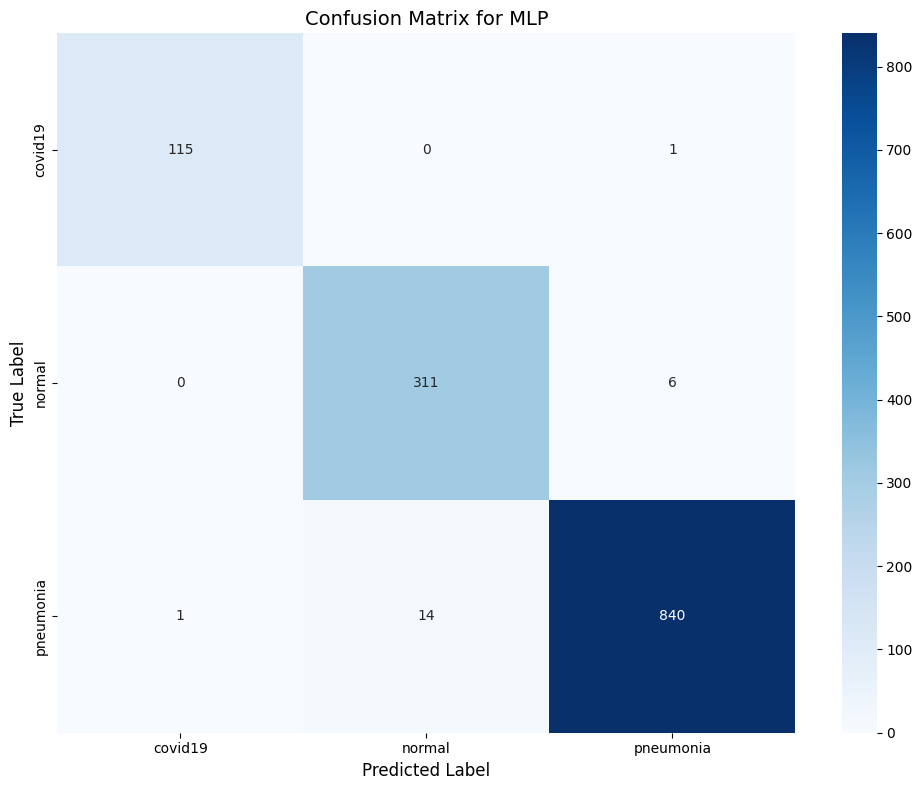

Accuracy: 0.9829
Precision: 0.9831
Recall: 0.9829
F1: 0.9830
Roc Auc: 0.9986
Inference Time: 0.0060 seconds


In [ ]:
# Generate and plot the confusion matrix for the best model
best_model_name = max(test_results, key=lambda k: test_results[k]["roc_auc"])
y_pred = all_predictions[best_model_name]

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test),
)
plt.title(f"Confusion Matrix for {best_model_name}", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

# Summary of best model performance
print("=" * 60)
for metric, value in test_results[best_model_name].items():
    if metric == "inference_time":
        print(f"{metric.replace('_', ' ').title()}: {value:.4f} seconds")
    else:
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
print("=" * 60)

Computing UMAP projections...


/anaconda/envs/haitk-py310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


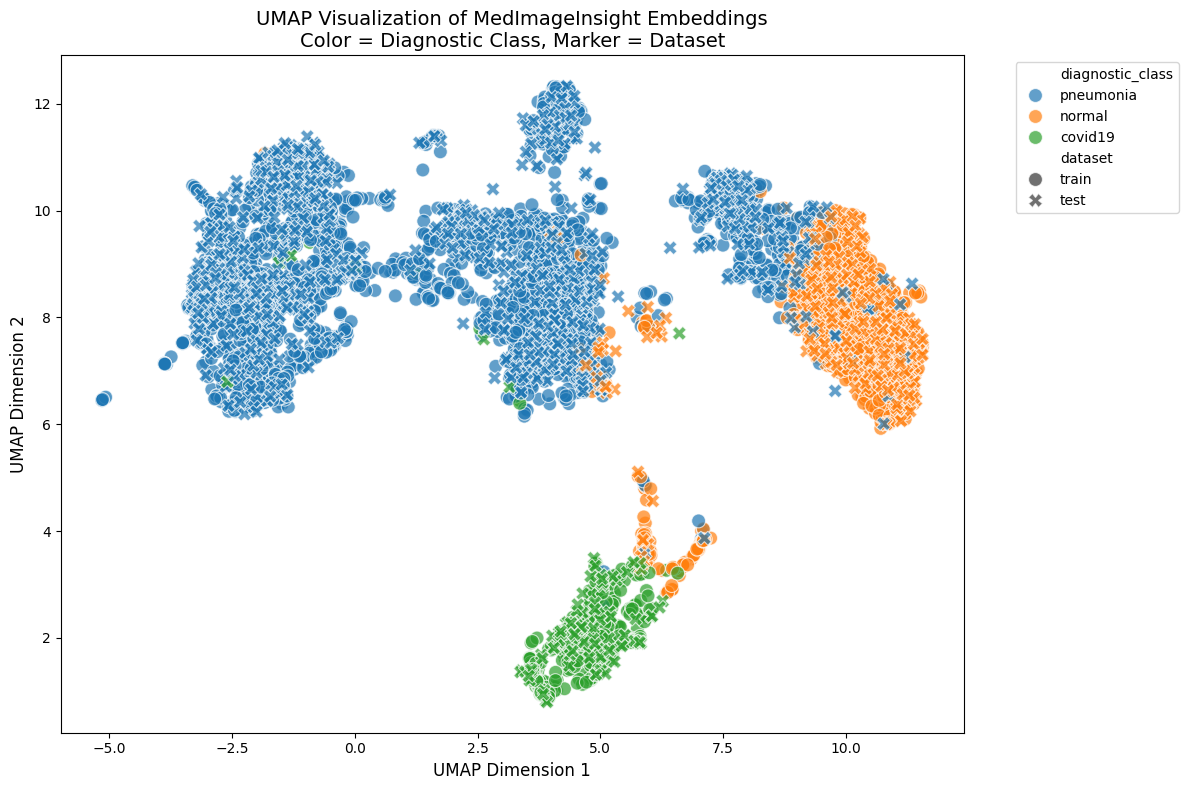

In [ ]:
import umap

# Fit UMAP on the training embeddings and transform both train and test
print("Computing UMAP projections...")
umapper = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_train_umap = umapper.fit_transform(X_train)
X_test_umap = umapper.transform(X_test)

# Combine UMAP projections for train and test
train_umap_df = pd.DataFrame(
    {
        "UMAP1": X_train_umap[:, 0],
        "UMAP2": X_train_umap[:, 1],
        "diagnostic_class": y_train,
        "dataset": "train",
    }
)

test_umap_df = pd.DataFrame(
    {
        "UMAP1": X_test_umap[:, 0],
        "UMAP2": X_test_umap[:, 1],
        "diagnostic_class": y_test,
        "dataset": "test",
    }
)

umap_df = pd.concat([train_umap_df, test_umap_df], ignore_index=True)

# Plot UMAP projections, using color for class and marker style for train/test
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=umap_df,
    x="UMAP1",
    y="UMAP2",
    hue="diagnostic_class",
    style="dataset",
    s=100,
    alpha=0.7,
)
plt.title(
    "UMAP Visualization of MedImageInsight Embeddings\nColor = Diagnostic Class, Marker = Dataset",
    fontsize=14,
)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()

Computing t-SNE projections (this may take a minute)...


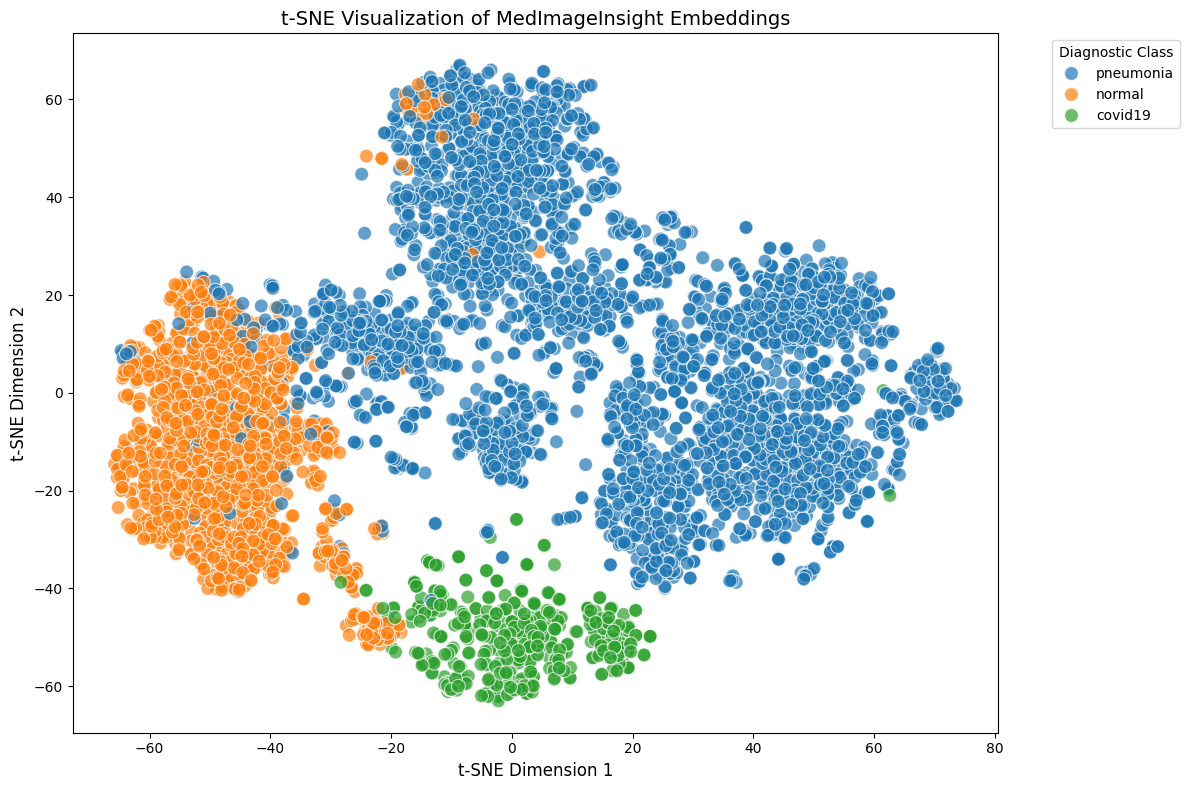

In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE to visualize the clustering of MedImageInsight embeddings
print("Computing t-SNE projections (this may take a minute)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_train)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(X_embedded, columns=["TSNE1", "TSNE2"])
tsne_df["diagnostic_class"] = y_train

# Plot the t-SNE visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="TSNE1",
    y="TSNE2",
    hue="diagnostic_class",
    palette="tab10",
    data=tsne_df,
    s=100,
    alpha=0.7,
)
plt.title("t-SNE Visualization of MedImageInsight Embeddings", fontsize=14)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.legend(
    title="Diagnostic Class", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10
)
plt.tight_layout()
plt.show()

Visualizing 8 correct and 4 incorrect predictions from MLP


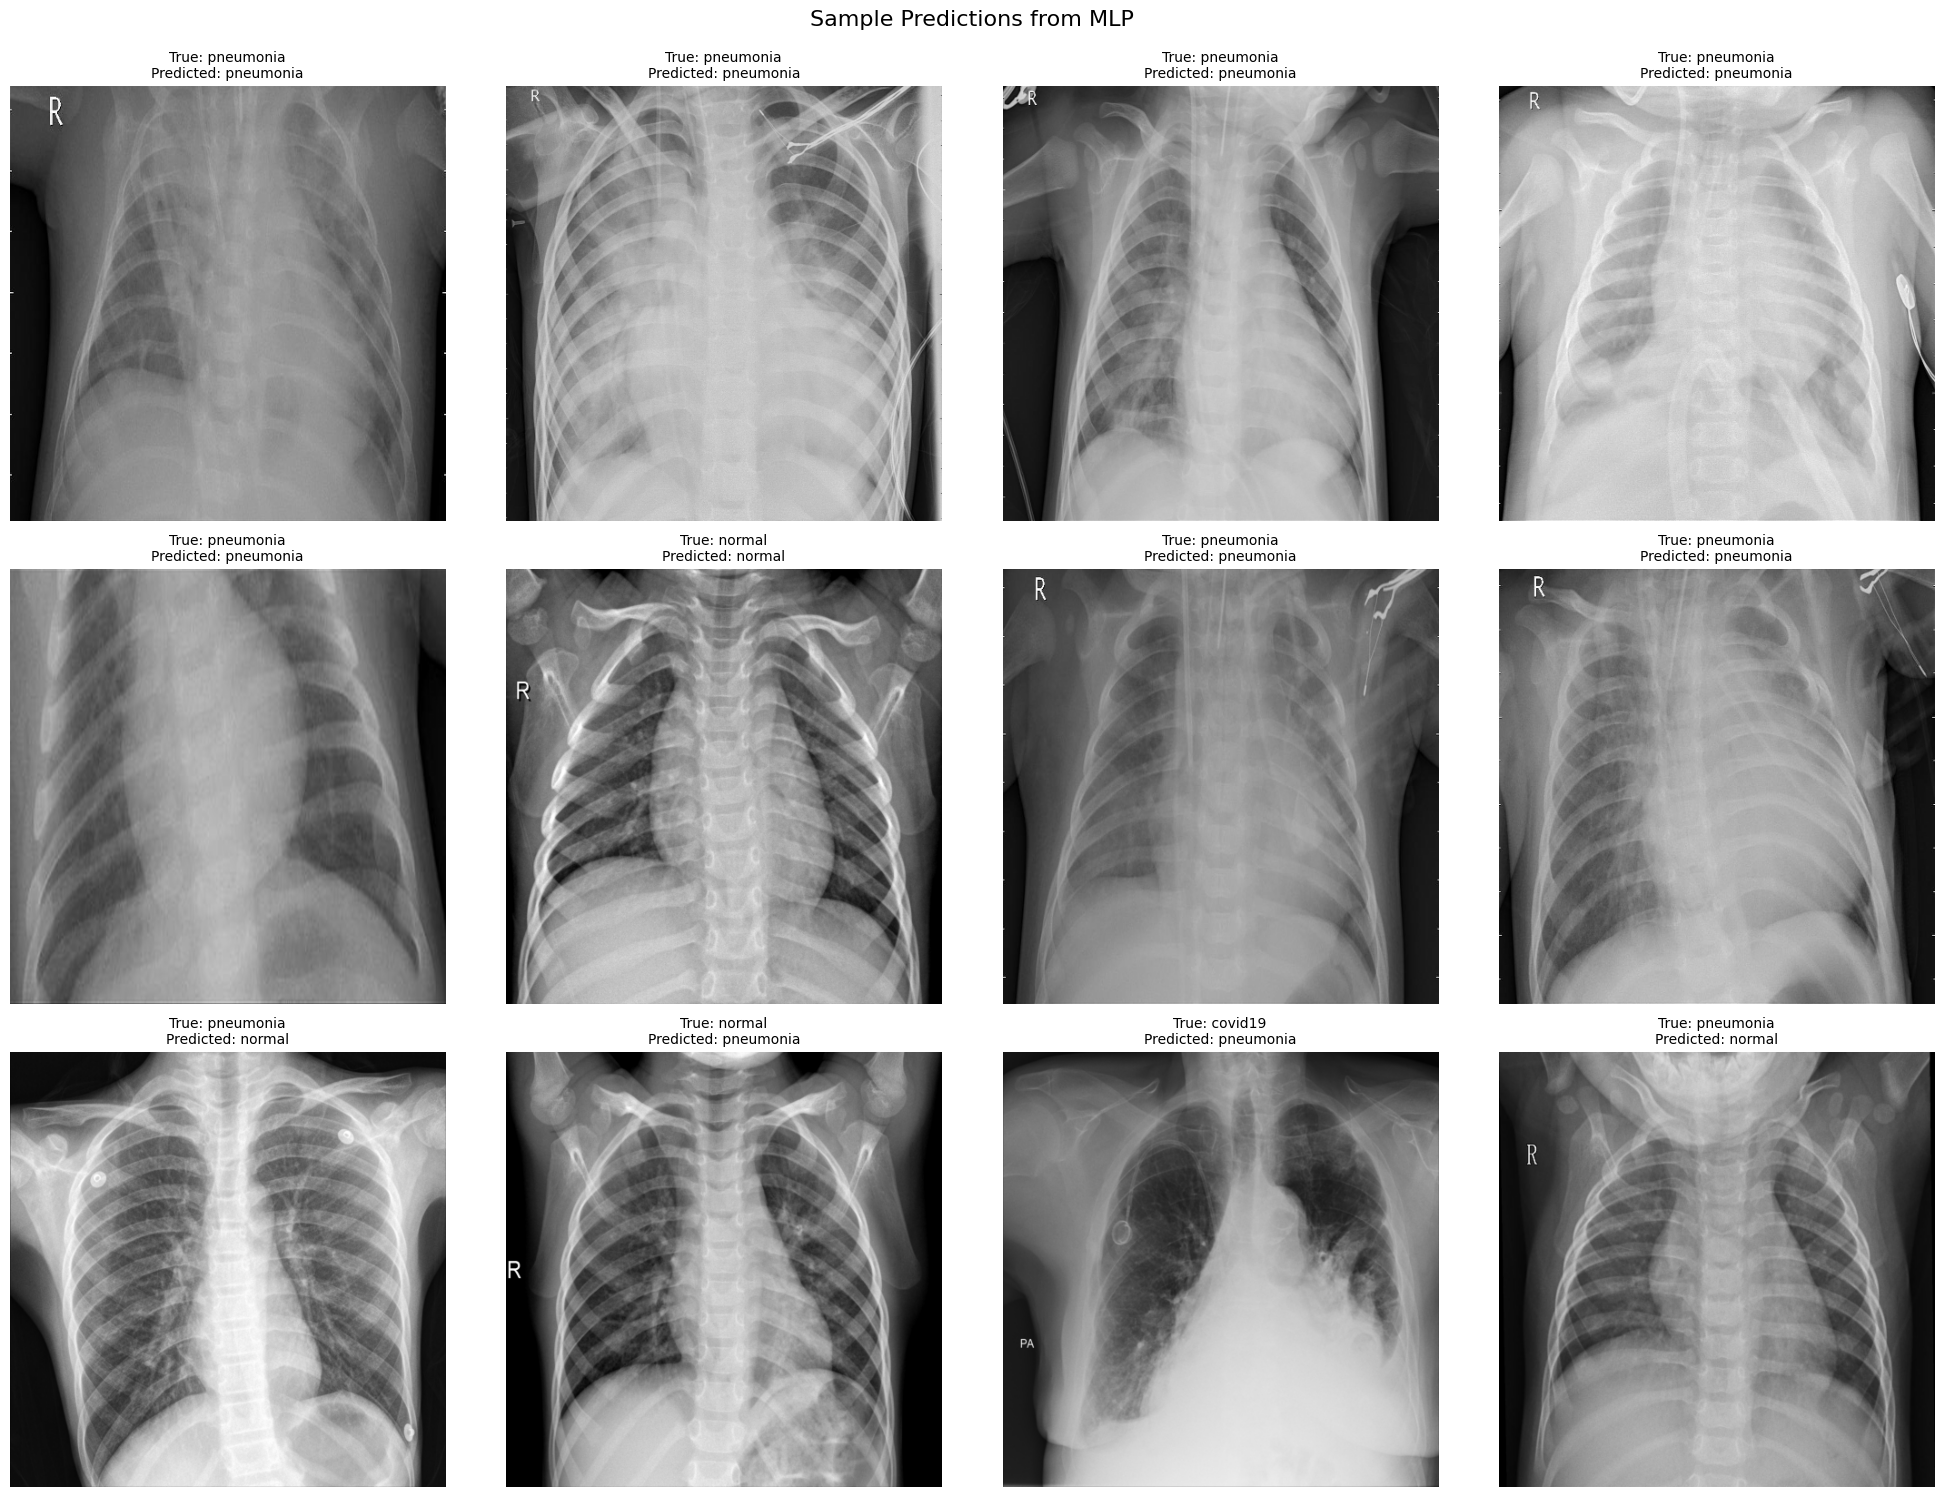

In [ ]:
from healthcareai_toolkit.clients import MedImageInsightClient

# Select sample predictions to visualize
best_correct = np.where(all_predictions[best_model_name] == y_test)[0]
best_incorrect = np.where(all_predictions[best_model_name] != y_test)[0]

# Randomly select samples (8 correct, 4 incorrect)
np.random.seed(42)
correct_samples = np.random.choice(
    best_correct, size=min(8, len(best_correct)), replace=False
)
incorrect_samples = np.random.choice(
    best_incorrect, size=min(4, len(best_incorrect)), replace=False
)
sample_indices = np.concatenate([correct_samples, incorrect_samples])

print(
    f"Visualizing {len(correct_samples)} correct and {len(incorrect_samples)} incorrect predictions from {best_model_name}"
)

# Visualize predictions
client = MedImageInsightClient()
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

for i, (ax, idx) in enumerate(zip(axs.flatten(), sample_indices)):
    row = test_embeddings_df.iloc[idx]
    image = client.read_and_normalize_image(os.path.join(data_root, row["image_path"]))

    ax.imshow(image, cmap="bone")
    ax.axis("off")

    # Build title with ground truth and prediction
    gt_label = row["label"]
    pred_label = all_predictions[best_model_name][idx]
    is_correct = pred_label == gt_label

    ax.set_title(f"True: {gt_label}\nPredicted: {pred_label}", fontsize=10)

plt.suptitle(f"Sample Predictions from {best_model_name}", fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

# Summary and Next Steps

## Key Takeaways

- **Classifier Comparison**: Different classifiers perform differently depending on embedding quality
- **Rapid Development**: Adapters train in seconds/minutes on CPU vs. hours of GPU training
- **Embedding Quality**: UMAP/t-SNE visualizations reveal how well classes separate

## Research Results

The full study (8,842 chest radiographs, University of Wisconsin) found:
- **MedImageInsight: 93.1% mAUC** — outperformed competing foundation models
- **SVM optimal** for most foundation models including MI2
- **Adapters beat fine-tuned CNNs** (87.2% mAUC) with minutes vs. hours of training

**Research Paper**: [From Embeddings to Accuracy: Comparing Foundation Models for Radiographic Classification](https://arxiv.org/abs/2505.10823)

**Blog Post**: [Medical Imaging Embeddings Bake-Off: How Microsoft's MedImageInsight Compares to Leading Models](https://aka.ms/hls-frontiers-mi2-bake-off-blog)

## Trying it with Your Data

1. Organize images with consistent directory structure
2. Create a loader function
3. Generate embeddings from your models, (only MI2 included here)
4. Run Part 2 to train and compare classifiers
5. Compare results from different models (not included here)
